# Does the Tourism Preferences Changes after COVID19?

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfnjji, ucfnlun, ucfnpar, ucfnrli.

In [172]:
# Import visualisation modules
import matplotlib as mpl 
%matplotlib inline 
import matplotlib.pyplot as plt 

#Import modules
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import os

import warnings 
warnings.simplefilter(action='ignore')
ox.__version__

'1.2.2'

## Airbnb data (Pre-precessing)

Aim: our dependent variable which represents the tourists' area(?) preference on choosing accommondation. 
It would be the estimates bookings of Airbnb listings in each area.

Workflow: 

    1. to get the number of review of all the listing has in the last 12 months,
    
    2. and calculate the estimates bookings for each Airbnb listings in the last 12 months according to review rate in London.
    
    3. ...sum up or times _an average length of stay_ (e.g. 5.5 nights)

### read in data

In [173]:
#Cachng the data
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """
    
    cache_data
    
    
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data) # <- This should show the docstring you've written

Help on function cache_data in module __main__:

cache_data(src: str, dest: str) -> str
    cache_data



In [174]:
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/JinJiang22/fsds_GroupWork/blob/main/data/' # source path

In [175]:
IA_2022 = pd.read_csv( cache_data(spath+'2022-09-10-listings.csv.gz?raw=true', ddir) )
IA_2022.info()
# we should filter out the columns we need.

Found data/2022-09-10-listings.csv.gz locally!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69358 entries, 0 to 69357
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            69354 non-null  object 
 1   listing_url                                   69357 non-null  object 
 2   scrape_id                                     69357 non-null  object 
 3   last_scraped                                  69357 non-null  object 
 4   source                                        69358 non-null  object 
 5   name                                          69337 non-null  object 
 6   description                                   67839 non-null  object 
 7   neighborhood_overview                         39966 non-null  object 
 8   picture_url                                   69358 non-null  object 
 9   host_id       

In [176]:
IA_2019 = pd.read_csv(cache_data(spath+'London-2019-11-listings.csv.gz?raw=true', ddir),low_memory=False)
IA_2019.info()
# we need to fix the data type.

Found data/London-2019-11-listings.csv.gz locally!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              85236 non-null  object
 1   name                            85236 non-null  object
 2   host_id                         85236 non-null  object
 3   host_name                       85236 non-null  object
 4   neighbourhood_group             85236 non-null  object
 5   neighbourhood                   85236 non-null  object
 6   latitude                        85236 non-null  object
 7   longitude                       85236 non-null  object
 8   room_type                       85236 non-null  object
 9   price                           85236 non-null  object
 10  minimum_nights                  85236 non-null  object
 11  number_of_reviews               85236 non-null  object


### clean data

In [177]:
# select the column we need
df_raw1 = IA_2022
df_raw2 = IA_2019
print(df_raw1.columns.to_list())
print(df_raw2.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

In [178]:
IA_2019.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_class,last_review_timestamp
0,9582415,Single/Twin/Double Ensuite near Twickenham Sta...,49602995,Daniela,,Richmond upon Thames,51.44473,-.379,Private room,35,1,47,2019-11-06,2.27,1,278,Private room,11/6/2019 0:00:00
1,23013522,"Spacious room with double bed for 2, Twickenham",70374572,Monk,,Hounslow,51.45867,-.34444,Private room,19,1,131,2019-11-06,6.52,3,23,Private room,11/6/2019 0:00:00
2,25796711,Stunning Central London Apartment Close The River,25587547,Matthew,,Hammersmith and Fulham,51.47398,-.21531,Entire home/apt,103,7,8,2019-11-06,.51,1,317,Entire home/apt,11/6/2019 0:00:00
3,29060134,Recently renovated fabulous four bedroom house,57607790,Shofraz,,Hillingdon,51.52716,-.44164,Entire home/apt,85,14,5,2019-11-06,.4,1,346,Entire home/apt,11/6/2019 0:00:00
4,30374086,Lovely cosy flat for 4 in Heart of North London,228095684,Yashar,,Barnet,51.59118,-.1667,Entire home/apt,85,3,16,2019-11-06,1.52,3,139,Entire home/apt,11/6/2019 0:00:00


#### filter out the columns (2022 dataset)

In [179]:
# select the columns we may need. All fields about review are reserved.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since','host_listings_count', 'host_total_listings_count', 
        'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights','minimum_minimum_nights', 'availability_365', 
        'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
        'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'reviews_per_month']

In [180]:
df1 = df_raw1[cols]
#df1.sample(5)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69358 entries, 0 to 69357
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           69354 non-null  object 
 1   listing_url                  69357 non-null  object 
 2   last_scraped                 69357 non-null  object 
 3   name                         69337 non-null  object 
 4   description                  67839 non-null  object 
 5   host_id                      69358 non-null  float64
 6   host_name                    69353 non-null  object 
 7   host_since                   69353 non-null  object 
 8   host_listings_count          69346 non-null  object 
 9   host_total_listings_count    69345 non-null  float64
 10  latitude                     69351 non-null  float64
 11  longitude                    69351 non-null  float64
 12  property_type                69351 non-null  object 
 13  room_type       

In [181]:
df1.sample(5)[['latitude','longitude', 'property_type', 'minimum_nights','number_of_reviews', 'number_of_reviews_ltm']]

,latitude,longitude,property_type,minimum_nights,number_of_reviews,number_of_reviews_ltm
37897,51.54366,0.11710,Private room in rental unit,3,1.0,0.0
46535,51.51853,-0.13869,Entire rental unit,3,0.0,0.0
4624,51.48977,-0.10134,Entire condo,4,17.0,2.0
18872,51.51083,-0.14522,Entire rental unit,3,26.0,0.0
41566,51.39972,-0.20201,Entire rental unit,1,0.0,0.0


#### fixing data type (2019 dataset)

In [182]:
df2 = IA_2019

In [183]:
df2['reviews_per_month']

0        2.27
1        6.52
2         .51
3          .4
4        1.52
         ... 
85231        
85232        
85233        
85234        
85235        
Name: reviews_per_month, Length: 85236, dtype: object

In [184]:
# there was some empty string in the dataset...
df2 = df2.replace(r'^\s*$', np.nan, regex=True)

In [185]:
# transfer "object" to numeric 
ints  = ['latitude', 'longitude', 'price', 
         'number_of_reviews', 'reviews_per_month','minimum_nights']
for i in ints:
    print(f"Converting {i}")
    df2[i] = df2[i].astype('float')

Converting latitude
Converting longitude
Converting price
Converting number_of_reviews
Converting reviews_per_month
Converting minimum_nights


In [186]:
# check that they have been changed to float
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              85068 non-null  object 
 1   name                            85056 non-null  object 
 2   host_id                         84912 non-null  object 
 3   host_name                       84900 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   84911 non-null  object 
 6   latitude                        84911 non-null  float64
 7   longitude                       84911 non-null  float64
 8   room_type                       84911 non-null  object 
 9   price                           84911 non-null  float64
 10  minimum_nights                  84911 non-null  float64
 11  number_of_reviews               84911 non-null  float64
 12  last_review                     

#### listings with missing values

##### check the missing values

keep "0-review" listings.

In [187]:
df1.isna().sum(axis=0).sort_values(ascending=False)[:12]

license                        69358
review_scores_value            17849
review_scores_checkin          17848
review_scores_location         17846
review_scores_communication    17815
review_scores_accuracy         17814
review_scores_cleanliness      17801
review_scores_rating           16792
reviews_per_month              16792
last_review                    16787
first_review                   16785
description                     1519
dtype: int64

In [188]:
df1[df1['number_of_reviews_ltm'].isna()]

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_listings_count,host_total_listings_count,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month
9103,10128178.0,https://www.airbnb.com/rooms/10128178,2022-09-11,Homely flat in Central Haggerston/Shoreditch,This is a lived in apartment with two medium s...,233649.0,Michelle,2010-09-13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23112,22063217.0,https://www.airbnb.com/rooms/22063217,2022-09-12,Beautiful Vintage Apartment - BRICK LANE,<b>The space</b><br />Parejas,1824036.0,Arya,2012-02-28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52563,53422816.0,https://www.airbnb.com/rooms/53422816,2022-09-11,"Spacious, central 1-bed flat in Zone 2 East Lo...",We've newly refurbished our 1-bed apartment fo...,30626999.0,Sitara,2015-04-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53487,53899858.0,https://www.airbnb.com/rooms/53899858,2022-09-12,Large 1 bed flat - Haggerston station/Shoreditch,Enjoy a stylish experience at this centrally-l...,233649.0,Michelle,2010-09-13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63388,670608541728038282,https://www.airbnb.com/rooms/670608541728038282,2022-09-11,Stunning one bedroom flat in London fields,A beautifully renovated Victorian flat on the ...,7969940.0,Jenny,2013-08-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64775,680821702646368182,https://www.airbnb.com/rooms/680821702646368182,2022-09-11,Cozy studio in the heart of Angel with garden.,Welcome to my lovely studio located in the hea...,8029384.0,Melania,2013-08-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66384,694611321916822413,https://www.airbnb.com/rooms/694611321916822413,2022-09-11,Perfect one bed in London Fields,"Kick back and relax in this calm, stylish spac...",7969940.0,Jenny,2013-08-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is 7 null values in column 'number_of_reviews_ltm' in IA_2022. After opening the Airbnb page for each listings, we can see they are active listings in operation and also have reviews. We assumpt that the value were losen for some unknown technical problem while scraping. However they make up a very small part of the dataset. 

Therefore, these listings would be dropped.

In [189]:
df2.isnull().sum(axis=0).sort_values(ascending=False)

neighbourhood_group               85236
last_review_timestamp             20298
reviews_per_month                 20298
last_review                       20298
host_name                           336
minimum_nights                      325
availability_365                    325
calculated_host_listings_count      325
number_of_reviews                   325
price                               325
room_type                           325
longitude                           325
latitude                            325
neighbourhood                       325
host_id                             324
name                                180
id                                  168
room_class                            0
dtype: int64

In [190]:
no_rev_2019 = df2[df2['reviews_per_month'].isna()]
no_rev_2019

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_class,last_review_timestamp
64938,38151,Double room/ lounge,163634,Lisa,NaN,Croydon,51.41940,-0.08722,Private room,65.0,1.0,0.0,NaN,NaN,1,365,Private room,NaN
64939,38950,Room 1 Large Double Bedroom - front ground floor,167107,Paul,NaN,Haringey,51.58730,-0.08606,Private room,45.0,1.0,0.0,NaN,NaN,4,90,Private room,NaN
64940,38995,ROOM IN CONTEMPORARY STYLE FLAT,167281,C,NaN,Southwark,51.47892,-0.06040,Private room,45.0,1.0,0.0,NaN,NaN,1,87,Private room,NaN
64941,40228,Room 4 Cosy Double Bedroom on First Floor,167107,Paul,NaN,Haringey,51.58860,-0.08805,Private room,29.0,1.0,0.0,NaN,NaN,4,45,Private room,NaN
64942,96008,Light airy double bedroom for rent,510424,Dionne,NaN,Lambeth,51.43923,-0.10421,Private room,80.0,2.0,0.0,NaN,NaN,1,365,Private room,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85231,39868875,"The Apartment, East London Village",13553423,Melissa,NaN,Waltham Forest,51.58208,-0.00915,Entire home/apt,70.0,3.0,0.0,NaN,NaN,1,88,Entire home/apt,NaN
85232,39869123,Elegant stylish modern house with amazing view!,21145791,Ingrid,NaN,Merton,51.40628,-0.23244,Private room,69.0,2.0,0.0,NaN,NaN,2,113,Private room,NaN
85233,39869214,Holland Road - Kensington Olympia,251922260,Christian,NaN,Hammersmith and Fulham,51.50244,-0.21547,Entire home/apt,90.0,3.0,0.0,NaN,NaN,4,63,Entire home/apt,NaN
85234,39869249,Functional single room 18 min to London Bridge,255372486,Nudrat,NaN,Bromley,51.35742,0.10764,Private room,30.0,2.0,0.0,NaN,NaN,4,1,Private room,NaN


In [191]:
# mapping these listings
df_t = no_rev_2019

In [192]:
gdf = gpd.GeoDataFrame(df_t, 
      geometry=gpd.points_from_xy(df_t.longitude, df_t.latitude, crs='epsg:4326'))

In [193]:
print(f"The bottom-left corner is {df_t.longitude.min()}, {df_t.latitude.min()}")
print(f"The top-right corner is {df_t.longitude.max()}, {df_t.latitude.max()}")

The bottom-left corner is -0.49668, 51.29813
The top-right corner is 0.28539, 51.67651


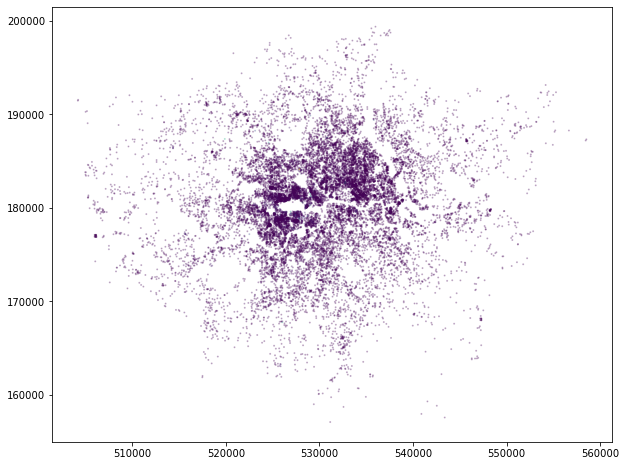

In [194]:
gdf.to_crs('EPSG: 27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

There are 20298 missing values in column 'reviews_per_month' in IA_2019. Obviously, We are not able to check each listing manually. 

Yet from the date frame table, it seems like they are a large number of listings which have no review at all but have other normal information, such as various room types and different prices. Can the 'no review' be evidence of inactiveness? Maybe they are just “part-time” Airbnb houses and have little bookings. 

Considering our aim is to calculate the occupancy rate for each listing and get the average occupancy rate for all the listings in each ward to represent the tourist’s preference, the amount of listings would affect the result directly. 

Additionaly, on the map above, it's shown that these listings locate around London.

Therefore, these ‘0-review’ listings are reserved and whose number of review/occupancy rate would be calculated as zero.

##### deal with df1 (2022 dataset)

In [195]:
# drop rows in df1 (2022 dataset)
df1.drop(df1[df1.number_of_reviews_ltm.isna()].index.array, axis=0, inplace=True)
# check
df1[df1.number_of_reviews_ltm.isna()]

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_listings_count,host_total_listings_count,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month


##### deal with df2 (2019 dataset)

In [196]:
df2.columns.get_loc("reviews_per_month")

13

In [197]:
df2.columns.get_loc("number_of_reviews")

11

In [198]:
# set 0 value to 'reviews_per_month' field for these "no-review" listings in df2 (2019 dataset)
# but there should be a more reproducable way to define rows with NA. For example, used the index of rows with NA.
df2.iloc[64938:85236,13] = 0

In [199]:
# check
df2.reviews_per_month.isna().sum()

0

### the occupancy model

The Occupancy Model is constructed by following the modified methodology from Inside Airbnb and ...

1. review rate

    A review rate of 50% is used to convert reviews to estimated bookings.

2. The average length of stay
The average length of stay is assumed as 5.3 days in this study and is taken from the Airbnb report and London first report.
Airbnb reported 5.4 nights as the average length of stay for guests using Airbnb in London, but the study examined data from November 2012 to October 2013.
London First study gave a figure of 5.3 nights on the average length of stay for international guests using Airbnb accommodation in London in 2019.

3. If a listing has a higher minimum nights value than the average length of stay, the minimum nights value was used instead.

#### estimate the length of stay

According to our third assumption in Occupancy model, if a listing has a higher minimum nights value than the average length of stay (5.3 days), the minimum nights value was used instead.

<AxesSubplot:>

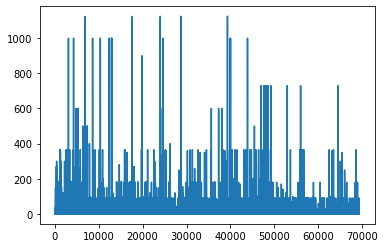

In [200]:
# have a look first
df1.minimum_minimum_nights.plot.line()

There are many listings set minumum nights as 365 or more than 1000 days, which must be an unreal situation. I assumpt it to be a temporary restrictions on booking. For these listings, we still use average length of stay as the estimate of length of stay. Additionaly, 90-days Airbnb Rule should also be considered. 
Therefore, we set the rule as below.

<AxesSubplot:>

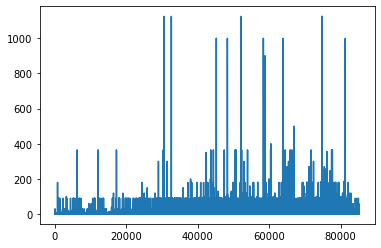

In [201]:
df2.minimum_nights.plot.line()

In [202]:
result = []
for n in df1.minimum_minimum_nights:
    if n < 5.3 or n > 90:
        result.append(5.3)
    else:
        night = n 
        result.append(night)
        
df1["leng_stay"] = result
df1[["leng_stay","minimum_nights"]].head(10)

,leng_stay,minimum_nights
0,5.3,1
1,5.3,3
2,5.3,5
3,5.3,3
4,5.3,4
5,5.3,4
6,5.3,2
7,14.0,14
8,5.3,3
9,5.3,3


In [203]:
result = []
for n in df2.minimum_nights:
    if n < 5.3 or n > 90:
        result.append(5.3)
    else:
        night = n 
        result.append(night)
        
df2["leng_stay"] = result
df2[["leng_stay","minimum_nights"]].head()

,leng_stay,minimum_nights
0,5.3,1.0
1,5.3,1.0
2,7.0,7.0
3,14.0,14.0
4,5.3,3.0


#### Calculate the occupancy rate

In [204]:
review_rate = 0.5

# Airbnb 2022 
df1['total_bookings_2022'] = df1['number_of_reviews_ltm']/ review_rate
df1['occupancy_rate_2022'] = df1['total_bookings_2022'] * df1['leng_stay']/ 365
df1[['occupancy_rate_2022','total_bookings_2022','number_of_reviews_ltm']]

,occupancy_rate_2022,total_bookings_2022,number_of_reviews_ltm
0,0.261370,18.0,9.0
1,0.000000,0.0,0.0
2,0.029041,2.0,1.0
3,0.000000,0.0,0.0
4,0.232329,16.0,8.0
...,...,...,...
69353,0.029041,2.0,1.0
69354,0.348493,24.0,12.0
69355,0.174247,12.0,6.0
69356,0.116164,8.0,4.0


In [205]:
# Airbnb 2019 
df2['total_bookings_2019'] = df2['reviews_per_month']*12 /review_rate
df2['occupancy_rate_2019'] = df2['total_bookings_2019'] * df2['leng_stay']/ 365
df2[['occupancy_rate_2019','total_bookings_2019','number_of_reviews','reviews_per_month','minimum_nights']]

,occupancy_rate_2019,total_bookings_2019,number_of_reviews,reviews_per_month,minimum_nights
0,0.791079,54.48,47.0,2.27,1.0
1,2.272175,156.48,131.0,6.52,1.0
2,0.234740,12.24,8.0,0.51,7.0
3,0.368219,9.60,5.0,0.40,14.0
4,0.529710,36.48,16.0,1.52,3.0
...,...,...,...,...,...
85231,0.000000,0.00,0.0,0.00,3.0
85232,0.000000,0.00,0.0,0.00,2.0
85233,0.000000,0.00,0.0,0.00,3.0
85234,0.000000,0.00,0.0,0.00,2.0


**Control Occupancy rate**

Some listings have comparatively large amount of review per month/year, so the estimated occupancy rate can be too large, up to 1 or even larger, maybe because of their real average length of stay is smaller than 5.3. 

The occupancy rate is capped at 70%, which is used in IA's "San Francisco Model", a relatively high, but reasonable number for a highly occupied "hotel".
Therefore, below is the final step to revise the estimated occupancy rate.

In [206]:
# control the occupancy rate as 70%
revised = []
for n in df2.occupancy_rate_2019:
    if n > 0.7:
        revised.append(0.7)
    else:
        revised.append(n)

df2["occupancy_rate_2019_revised"] = revised 
df2["occupancy_rate_2019_revised"]

0        0.700000
1        0.700000
2        0.234740
3        0.368219
4        0.529710
           ...   
85231    0.000000
85232    0.000000
85233    0.000000
85234    0.000000
85235    0.000000
Name: occupancy_rate_2019_revised, Length: 85236, dtype: float64

In [207]:
# control the occupancy rate as 70%
revised2022 = []
for n in df1.occupancy_rate_2022:
    if n > 0.7:
        revised2022.append(0.7)
    else:
        revised2022.append(n)

df1["occupancy_rate_2022_revised"] = revised2022
df1["occupancy_rate_2022_revised"]

0        0.261370
1        0.000000
2        0.029041
3        0.000000
4        0.232329
           ...   
69353    0.029041
69354    0.348493
69355    0.174247
69356    0.116164
69357    0.493699
Name: occupancy_rate_2022_revised, Length: 69351, dtype: float64

<AxesSubplot:ylabel='Frequency'>

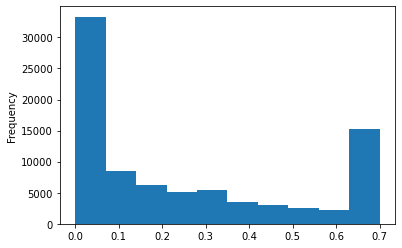

In [208]:
df2["occupancy_rate_2019_revised"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

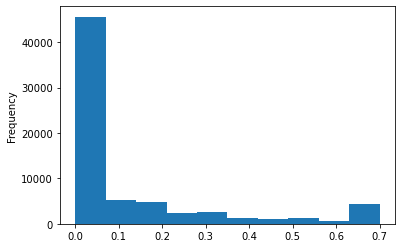

In [209]:
df1["occupancy_rate_2022_revised"].plot.hist()

### Join Airbnb listings with ward

#### read in London ward geodata

In [210]:
# Add London Ward Boundary Data
# this can be deleted after combining our notebooks.
londonward = gpd.read_file( cache_data(spath+'2011_london_ward.gpkg?raw=true', ddir) )

Found data/2011_london_ward.gpkg locally!


In [211]:
londonward.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

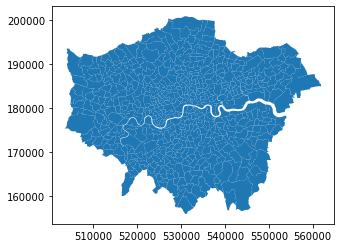

In [212]:
londonward.plot()

#### transfer csv to geodata

In [213]:
gdf_Airbnb2022 = gpd.GeoDataFrame(df1, 
      geometry=gpd.points_from_xy(df1.longitude, df1.latitude, crs='epsg:4326'))

In [214]:
gdf_Airbnb2019 = gpd.GeoDataFrame(df2, 
      geometry=gpd.points_from_xy(df2.longitude, df2.latitude, crs='epsg:4326'))

In [215]:
for g in [gdf_Airbnb2019]:
    print(g.crs)

epsg:4326


In [216]:
print(gdf_Airbnb2019.geometry.crs)
print(gdf_Airbnb2019.total_bounds)
print(gdf_Airbnb2022.geometry.crs)
print(gdf_Airbnb2022.total_bounds)

epsg:4326
[-0.49668 51.29479  0.28539 51.68169]
epsg:4326
[-5.236000e-01  2.000000e+00  1.125000e+03  5.170893e+01]


#### reproject the Airbnb

In [217]:
# check its crs
gdf_Airbnb2019 = gdf_Airbnb2019.to_crs('EPSG:27700')
gdf_Airbnb2022 = gdf_Airbnb2022.to_crs('EPSG:27700')
print(gdf_Airbnb2019.geometry.crs)
print(gdf_Airbnb2019.total_bounds)
print(gdf_Airbnb2022.geometry.crs)
print(gdf_Airbnb2022.total_bounds)

EPSG:27700
[504189.9384281  157077.66437635 558509.91187284 199932.45808543]
EPSG:27700
[  502615.87511762 -5304347.19481622               inf               inf]


We found there are some junk rows with random wrong information in latitude and longitude columns. So we choose to clip our data with London Boundary.

In [218]:
# Clip the data using GeoPandas clip
gdf_Airbnb2022_clip = gpd.clip(gdf_Airbnb2022, londonward)

In [219]:
print(f"Data frame of Airbnb 2022 after clipping is {gdf_Airbnb2022_clip.shape[0]} x {gdf_Airbnb2022_clip.shape[1]}")
print(f"Data frame of Airbnb 2019 is {gdf_Airbnb2019.shape[0]} x {gdf_Airbnb2019.shape[1]}")

Data frame of Airbnb 2022 after clipping is 68590 x 40
Data frame of Airbnb 2019 is 85236 x 23


<AxesSubplot:ylabel='Frequency'>

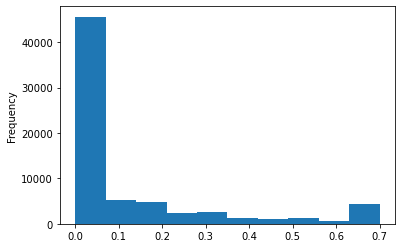

In [220]:
gdf_Airbnb2022["occupancy_rate_2022_revised"].plot.hist()

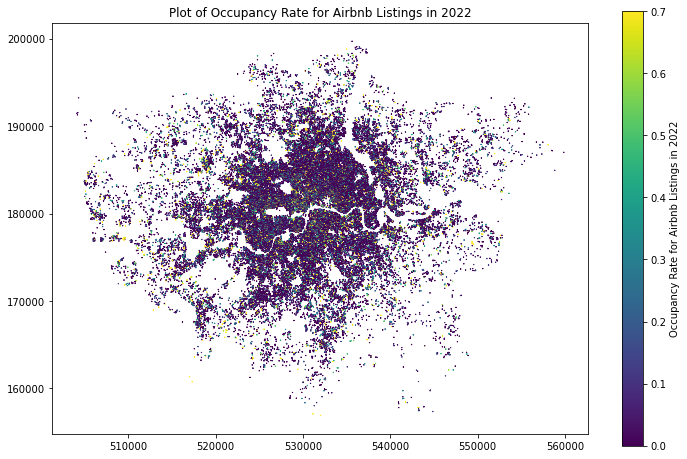

In [221]:
# plot Airbnb listings in 2019
ax = gdf_Airbnb2022_clip.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='occupancy_rate_2022_revised', cmap='viridis', 
         legend=True, legend_kwds={"label": "Occupancy Rate for Airbnb Listings in 2022"});  #legend_kwds: legend keywords
ax.set_title("Plot of Occupancy Rate for Airbnb Listings in 2022");

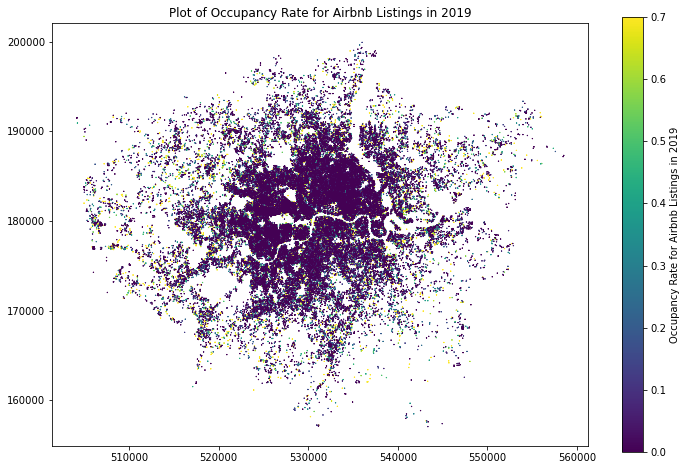

In [222]:
# plot Airbnb listings in 2019
ax = gdf_Airbnb2019.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='occupancy_rate_2019_revised', cmap='viridis', 
         legend=True, legend_kwds={"label": "Occupancy Rate for Airbnb Listings in 2019"});  #legend_kwds: legend keywords
ax.set_title("Plot of Occupancy Rate for Airbnb Listings in 2019");

<AxesSubplot:>

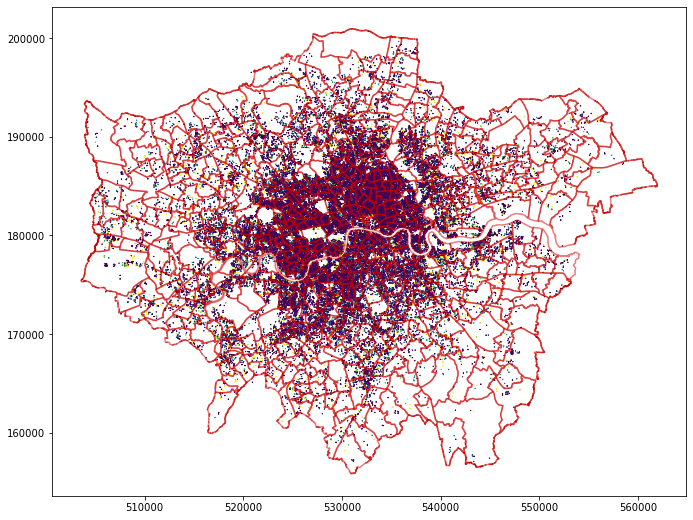

In [223]:
# Plot Airbnb listings and London ward to the same axes
# to have a look.
# Creates a new figure with specified number of subplots and the specified size (in inches by default).
fig, ax = plt.subplots(1,1, figsize=(12,9))

gdf_Airbnb2019.plot(column='occupancy_rate_2019_revised', marker='*', markersize=0.25, cmap='viridis', ax=ax)
londonward.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=1.5, ax=ax)

#### join two datasets and calculate the variable

We use spatial join to define Airbnb listings in each ward. Then, group by and calculate the average occupancy rate of each ward as the dependent variable.

In [224]:
Airbnb2019_in_ward = gdf_Airbnb2019.sjoin(londonward, how="inner", predicate='intersects')
Airbnb2019_in_ward.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review_timestamp,leng_stay,total_bookings_2019,occupancy_rate_2019,occupancy_rate_2019_revised,geometry,index_right,geo_labelw,geo_label,geo_code
0,9582415,Single/Twin/Double Ensuite near Twickenham Sta...,49602995,Daniela,NaN,Richmond upon Thames,51.44473,-0.37900,Private room,35.0,...,11/6/2019 0:00:00,5.3,54.48,0.791079,0.700000,POINT (512750.672 172994.812),544,None,Heathfield,E05000523
3802,14236471,Ensuite single modern room in twickenham,86566410,Yorgo,NaN,Richmond upon Thames,51.44941,-0.36235,Private room,27.0,...,11/1/2019 0:00:00,5.3,53.52,0.777140,0.700000,POINT (513896.087 173540.987),544,None,Heathfield,E05000523
4292,35463539,2 Bed Semi on 1 level Free parking Wi-Fi & Ga...,266812235,Derek,NaN,Richmond upon Thames,51.44694,-0.38079,Entire home/apt,85.0,...,11/1/2019 0:00:00,5.3,38.16,0.554104,0.554104,POINT (512620.848 173237.826),544,None,Heathfield,E05000523
5224,36389486,Double Room in Lovely Home -Twickenham,30537142,Lizzette&Barnaby,NaN,Richmond upon Thames,51.44624,-0.36824,Private room,24.0,...,10/31/2019 0:00:00,5.3,47.04,0.683047,0.683047,POINT (513494.671 173179.332),544,None,Heathfield,E05000523
7403,32174432,2 Bed Bungalow+garden+parking Free Wi-fi,80107186,Jenny,NaN,Richmond upon Thames,51.44810,-0.38174,Entire home/apt,85.0,...,10/28/2019 0:00:00,5.3,74.64,1.083814,0.700000,POINT (512551.984 173365.366),544,None,Heathfield,E05000523


In [225]:
Airbnb2022_in_ward = gdf_Airbnb2022_clip.sjoin(londonward, how="inner", predicate='intersects')
Airbnb2022_in_ward.head()

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_listings_count,host_total_listings_count,...,reviews_per_month,leng_stay,total_bookings_2022,occupancy_rate_2022,occupancy_rate_2022_revised,geometry,index_right,geo_labelw,geo_label,geo_code
52718,53453460.0,https://www.airbnb.com/rooms/53453460,2022-09-10,Log cabin rurally located 1 bedroom,Rurally located log cabin with great transport...,432830379.0,Daniel,2021-11-21,1.0,1.0,...,NaN,5.3,0.0,0.000000,0.000000,POINT (548891.184 163761.884),324,None,Chelsfield and Pratts Bottom,E05000110
49451,50849897.0,https://www.airbnb.com/rooms/50849897,2022-09-11,Secluded Log cabin surrounded with nature,Relax with the whole family at this peaceful p...,75151381.0,Evie,2016-06-01,2.0,2.0,...,1.47,5.3,28.0,0.406575,0.406575,POINT (548755.366 163927.091),324,None,Chelsfield and Pratts Bottom,E05000110
57683,614802885788128798,https://www.airbnb.com/rooms/614802885788128798,2022-09-10,Luxury accommodation with use of kitchen/lounge,Beautiful bedroom with king size bed in a grad...,150690857.0,Michelle,2017-09-15,1.0,1.0,...,1.84,5.3,6.0,0.087123,0.087123,POINT (548251.177 164108.310),324,None,Chelsfield and Pratts Bottom,E05000110
56052,589178624979678208.0,https://www.airbnb.com/rooms/589178624979678210,2022-09-11,Delightful granary studio,A very old granary lovingly converted into a l...,36224509.0,Lou,2015-06-19,1.0,1.0,...,NaN,5.3,0.0,0.000000,0.000000,POINT (548713.432 164117.083),324,None,Chelsfield and Pratts Bottom,E05000110
47151,48583067,https://www.airbnb.com/rooms/48583067,2022-09-11,Luxury London Sunset Glamping Tent and Field,Luxurious 5 metre bell tent with proper double...,391124223.0,Kieran,2021-03-04,1.0,1.0,...,1.17,5.3,12.0,0.174247,0.174247,POINT (546299.382 161432.323),324,None,Chelsfield and Pratts Bottom,E05000110


In [227]:
# calculate the average occupancy rate in each ward
aver_occup_rate_2019 = Airbnb2019_in_ward.groupby('geo_code')['occupancy_rate_2019_revised'].mean()
aver_occup_rate_2019.head()

geo_code
E05000001    0.317288
E05000015    0.149882
E05000026    0.240206
E05000027    0.295671
E05000028    0.139687
Name: occupancy_rate_2019_revised, dtype: float64

In [228]:
# calculate the average occupancy rate in each ward
aver_occup_rate_2022 = Airbnb2022_in_ward.groupby('geo_code')['occupancy_rate_2022_revised'].mean()
aver_occup_rate_2022.head()

geo_code
E05000001    0.129800
E05000015    0.143836
E05000026    0.115240
E05000027    0.077788
E05000028    0.132107
Name: occupancy_rate_2022_revised, dtype: float64

In [229]:
# join the average rate back to ward
Ward_Airbnb_2019 = londonward.merge(aver_occup_rate_2019, on='geo_code', how='left')
Ward_Airbnb_2019.head()

,geo_labelw,geo_label,geo_code,geometry,occupancy_rate_2019_revised
0,None,Cazenove,E05000232,"MULTIPOLYGON (((533654.384 186936.977, 533654....",0.178328
1,None,Leytonstone,E05000605,"MULTIPOLYGON (((538967.707 187911.084, 538978....",0.216254
2,None,Woodhouse,E05000063,"MULTIPOLYGON (((526331.163 192341.020, 526330....",0.142844
3,None,New Cross,E05000449,"MULTIPOLYGON (((535270.209 177501.208, 535270....",0.227013
4,None,Sudbury,E05000101,"MULTIPOLYGON (((515678.796 185893.064, 515680....",0.393321


In [230]:
# join the average rate back to ward
Ward_Airbnb_2022 = londonward.merge(aver_occup_rate_2022, on='geo_code', how='left')
Ward_Airbnb_2022.head()

,geo_labelw,geo_label,geo_code,geometry,occupancy_rate_2022_revised
0,None,Cazenove,E05000232,"MULTIPOLYGON (((533654.384 186936.977, 533654....",0.057010
1,None,Leytonstone,E05000605,"MULTIPOLYGON (((538967.707 187911.084, 538978....",0.096739
2,None,Woodhouse,E05000063,"MULTIPOLYGON (((526331.163 192341.020, 526330....",0.084639
3,None,New Cross,E05000449,"MULTIPOLYGON (((535270.209 177501.208, 535270....",0.086953
4,None,Sudbury,E05000101,"MULTIPOLYGON (((515678.796 185893.064, 515680....",0.153050


#### deal with the outlier

### Save file locally

create an folder to save analytical output.

In [231]:
# create an folder to save analytical output.
path = os.path.join('data','analytical') # A default location to save data
#fn   = url.split('/')[-1]         # What does this do?  #Jin: the filename is contained in the url after the last slash

#print(f"Writing to: {fn}")
#print(url)
print(path)

data/analytical


save csv file locally

In [232]:
if not os.path.exists(path):      # And what does *this* do?   #Jin: if the pathway does not exist, then create one.
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)

gdf1 = Ward_Airbnb_2022
gdf2 = Ward_Airbnb_2019
gdf1.to_csv(os.path.join(path, "Ward_Airbnb_2022.csv"), index=False)
gdf2.to_csv(os.path.join(path, "Ward_Airbnb_2019.csv"), index=False)
print("Done.")

Done.


save map plot file locally

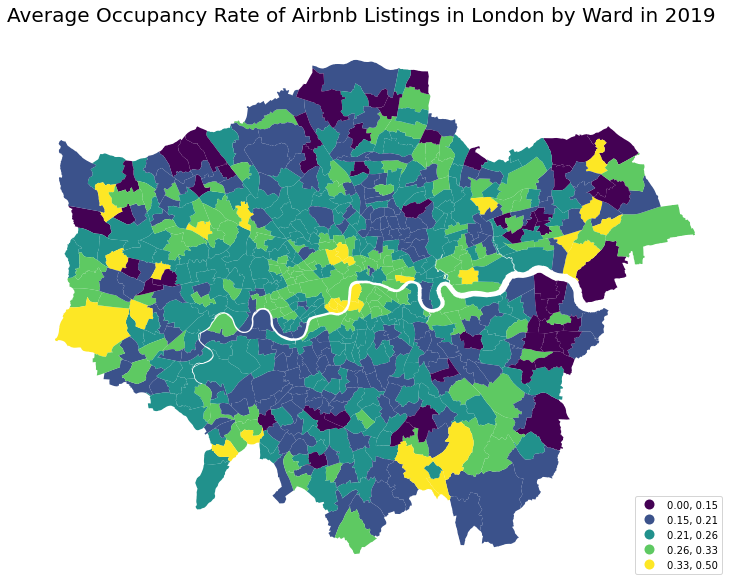

In [234]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(15,10))
fig.suptitle(f"Average Occupancy Rate of Airbnb Listings in London by Ward in 2019", fontsize=20, y=0.92)
Ward_Airbnb_2019.plot(ax=ax, scheme='natural_breaks', legend_kwds={"loc": 4}, column='occupancy_rate_2019_revised',legend=True)

# Save the image
ax.set_axis_off()
if not os.path.exists(path):      # And what does *this* do?   #Jin: if the pathway does not exist, then create one.
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)

plt.savefig(os.path.join(path,'occupancy_rate_Airbnb_Ward_2019.png'), dpi=300)

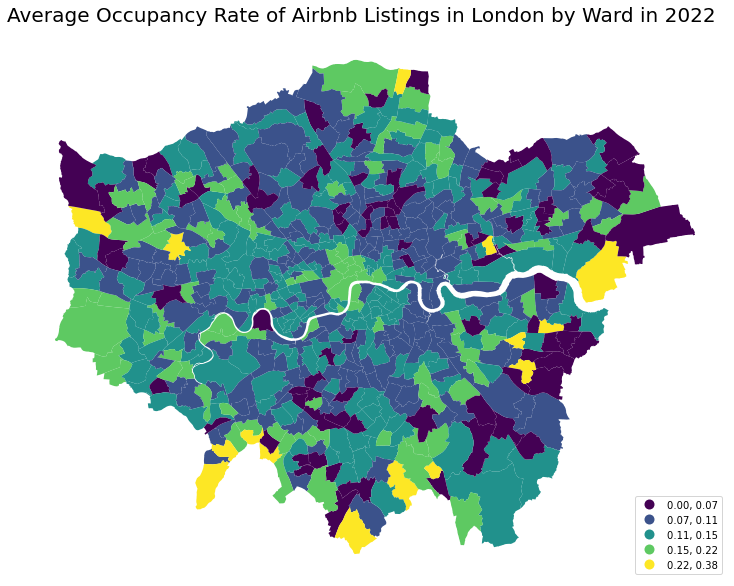

In [235]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(15,10))
fig.suptitle(f"Average Occupancy Rate of Airbnb Listings in London by Ward in 2022", fontsize=20, y=0.92)
Ward_Airbnb_2022.plot(ax=ax, scheme='natural_breaks', legend_kwds={"loc": 4}, column='occupancy_rate_2022_revised',legend=True)

ax.set_axis_off()

# Save the image
if not os.path.exists(path):      # And what does *this* do?   #Jin: if the pathway does not exist, then create one.
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)

plt.savefig(os.path.join(path,'occupancy_rate_2022.png'), dpi=300)

## Analysis

### change between

In [236]:
# add to a dataframe
Ward_Airbnb_2022["occupancy_rate_2019_revised"] = Ward_Airbnb_2019["occupancy_rate_2019_revised"]
Ward_Airbnb_2022[["occupancy_rate_2019_revised","geo_code"]]

,occupancy_rate_2019_revised,geo_code
0,0.178328,E05000232
1,0.216254,E05000605
2,0.142844,E05000063
3,0.227013,E05000449
4,0.393321,E05000101
...,...,...
702,NaN,E05007391
703,0.168904,E05000424
704,0.196120,E05000030
705,0.302276,E05000302


In [237]:
Ward_Airbnb_2022["change_occpc_rate"] = Ward_Airbnb_2022["occupancy_rate_2022_revised"]-Ward_Airbnb_2022["occupancy_rate_2019_revised"] 

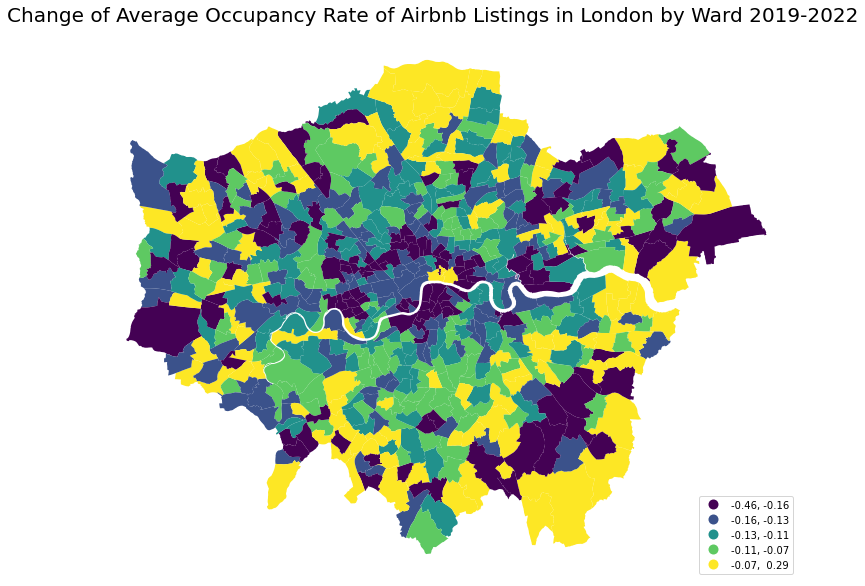

In [238]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(15,10))
fig.suptitle(f"Change of Average Occupancy Rate of Airbnb Listings in London by Ward 2019-2022", fontsize=20, y=0.92)
Ward_Airbnb_2022.plot(ax=ax, 
                      scheme='quantiles', legend_kwds={"loc": 4},column='change_occpc_rate',legend=True)

ax.set_axis_off()
# Save the image
if not os.path.exists(path):      # And what does *this* do?   #Jin: if the pathway does not exist, then create one.
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)

plt.savefig(os.path.join(path,'occupancy_rate_change.png'), dpi=300)